Source: https://www.kaggle.com/qiubit/the-nature-conservancy-fisheries-monitoring/detecting-night-photos.

# Detecting night photos

In the dataset, there are both day and night photos. Theoretically, it should be a good idea to train separate CNNs for them, as the color distribution is somewhat different, and, because of this, joining both types of photos in one dataset could be inefficient when it comes to training a CNN. The following notebook explores the idea of detecting day and night photos and separating them.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="dark")

In [2]:
import cv2
import glob
import random
import os
from tqdm import tqdm
from sklearn import cluster

It seems obvious that "night" photos are a little bit more greenish. Let's explore this a little more.

Let's plot some images alongside with mean of their components (R/G/B) below.

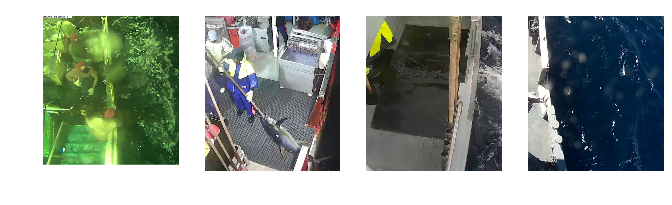

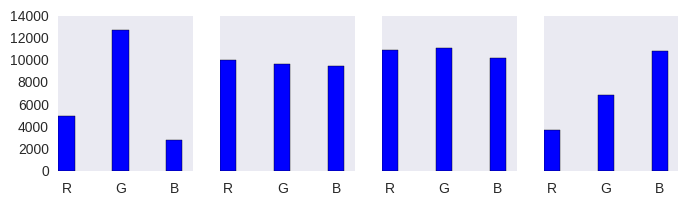

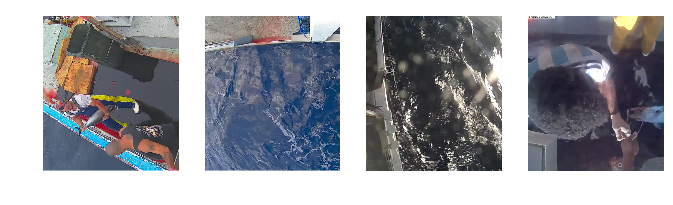

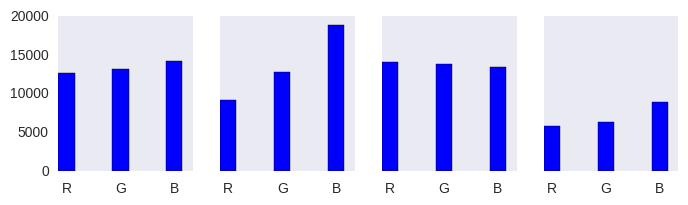

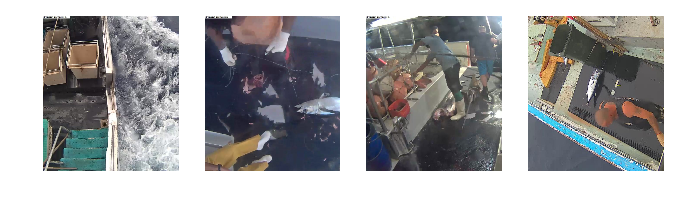

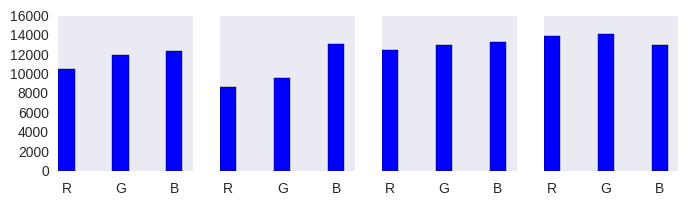

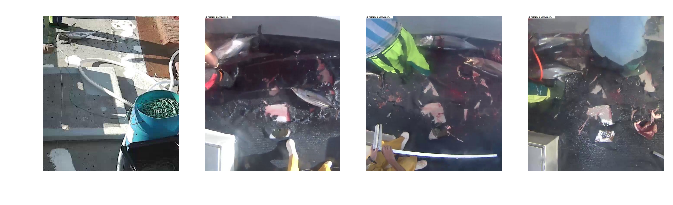

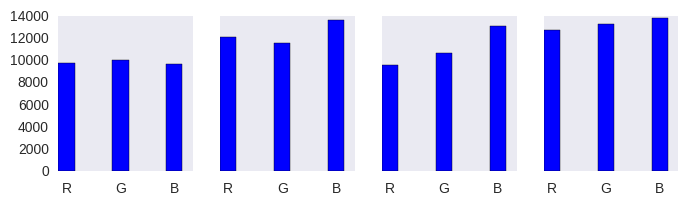

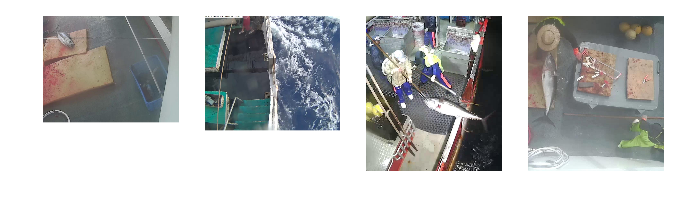

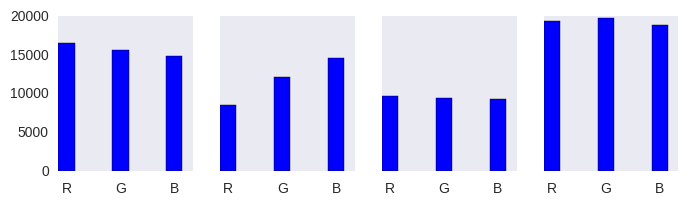

In [3]:
# load images
imgs_to_load = 20

preview_files = sorted(glob.glob('../data/train/*/*.jpg'),
                       key=lambda x: random.random())[:imgs_to_load]
preview = np.array([cv2.imread(img)[:,:,::-1] for img in preview_files])

def show_loaded_with_means(imgs):
    rows_total = int(len(preview) / 4)
    for i in range(rows_total):
        _, img_ax = plt.subplots(1, 4, sharex='col', sharey='row',
                                 figsize=(8, 2))
        _, imgmean_ax = plt.subplots(1, 4, sharex='col', sharey='row',
                                     figsize=(8, 2))
        for j in range(4):
            img = preview[i*4+j]
            img_mean = np.mean(img, axis=(0,1))
            # calculate squared means to amplify green dominance effect
            img_mean = np.power(img_mean, 2)
            
            # show plots
            img_ax[j].axis('off')
            img_ax[j].imshow(img)
            imgmean_ax[j].bar(range(3), img_mean, width=0.3, color='blue')
            imgmean_ax[j].set_xticks(np.arange(3) + 0.3 / 2)
            imgmean_ax[j].set_xticklabels(['R', 'G', 'B'])

show_loaded_with_means(preview)
plt.show()

It can be seen that in night photos, green component shows clear dominance over R/B components, when it comes to its mean. This is something that should be easily picked up by k-means algorithm.

Before applying it, let's first explore one more idea for representing each training image. If G component dominance is something that determines whether photo is day or night, we could, for mean of each component, store sum of differences between it and different component means. That way, dominance would mean higher number, and non-dominance would be punished. We will create 3 features (for all R, G, B differences).

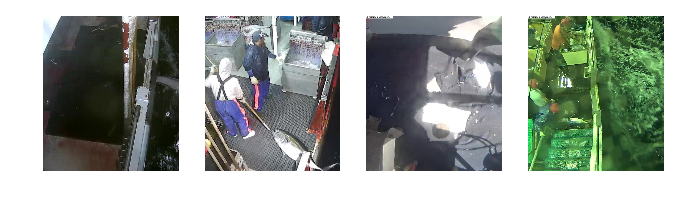

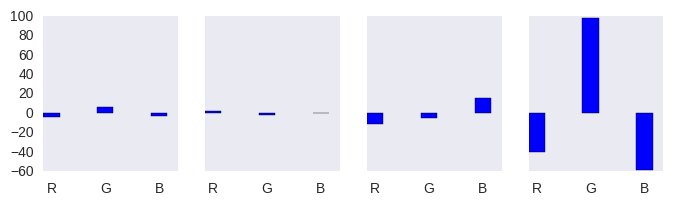

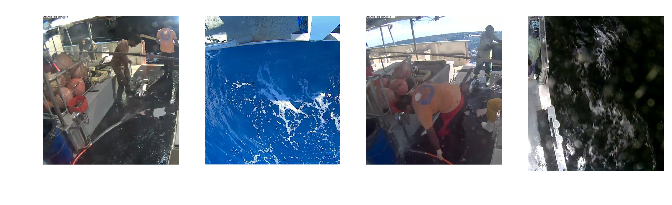

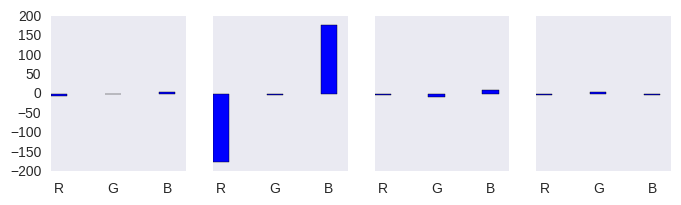

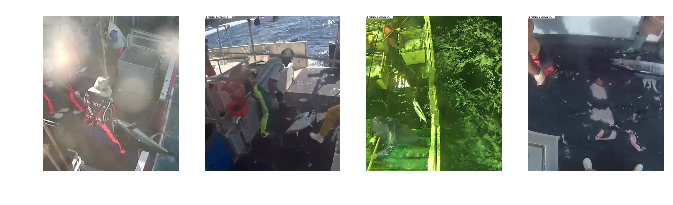

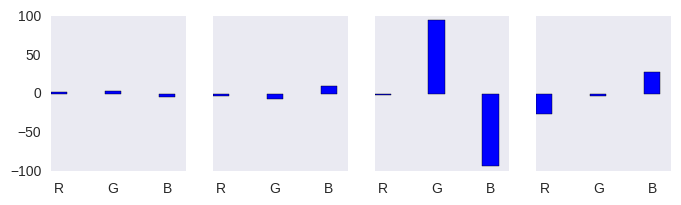

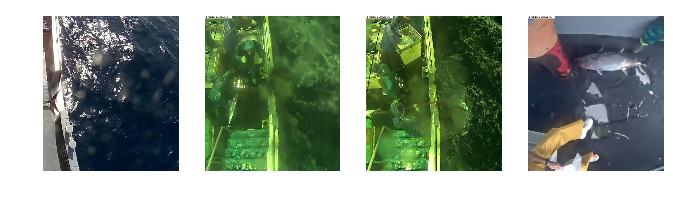

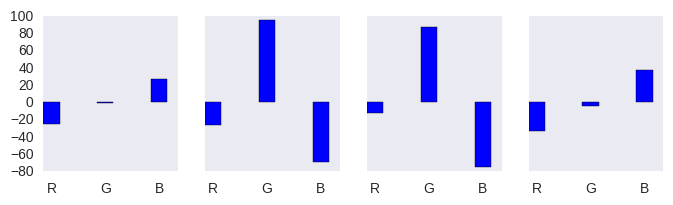

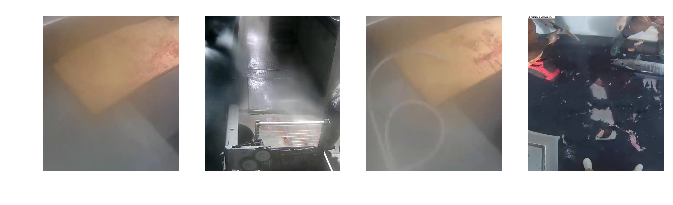

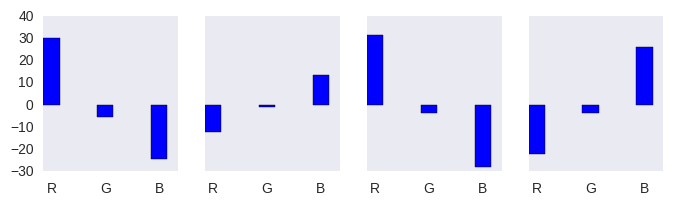

In [4]:
imgs_to_load = 20

preview_files = sorted(glob.glob('../data/train/*/*.jpg'),
                       key=lambda x: random.random())[:imgs_to_load]
preview = np.array([cv2.imread(img)[:,:,::-1] for img in preview_files])

def show_loaded_with_mean_differences(imgs):
    rows_total = int(len(preview) / 4)
    for i in range(rows_total):
        _, img_ax = plt.subplots(1, 4, sharex='col', sharey='row',
                                 figsize=(8, 2))
        _, imgmean_ax = plt.subplots(1, 4, sharex='col', sharey='row',
                                     figsize=(8, 2))
        for j in range(4):
            # calculate features of an image
            img = preview[i*4+j]
            img_mean = np.mean(img, axis=(0,1))
            img_features = np.zeros(3)
            img_features[0] = (img_mean[0] - img_mean[1]) + (img_mean[0]
                                                             - img_mean[2])
            img_features[1] = (img_mean[1] - img_mean[0]) + (img_mean[1]
                                                             - img_mean[2])
            img_features[2] = (img_mean[2] - img_mean[0]) + (img_mean[2]
                                                             - img_mean[1])
            
            # display plots
            img_ax[j].axis('off')
            img_ax[j].imshow(img)
            imgmean_ax[j].bar(range(3), img_features, width=0.3, color='blue')
            imgmean_ax[j].set_xticks(np.arange(3) + 0.3 / 2)
            imgmean_ax[j].set_xticklabels(['R', 'G', 'B'])

show_loaded_with_mean_differences(preview)
plt.show()

Looks promising - it seems high G component values are only achieved by night photos! This is the approach we'll use with k-means.

In [5]:
# one cluster will be day photos, the other one night photos
knn_cls = 2
# increase this number while training locally for better results
training_imgs = 50

training_files = sorted(glob.glob('../data/train/*/*.jpg'),
                        key=lambda x: random.random())[:training_imgs]
training = np.array([cv2.imread(img)[:,:,::-1] for img in training_files])
training_means = np.array([np.mean(img, axis=(0, 1)) for img in training])
training_features = np.zeros((training_imgs, 3))
for i in range(training_imgs):
    training_features[i][0] = (training_means[i][0] - training_means[i][1])
    training_features[i][0] += (training_means[i][0] - training_means[i][2])
    training_features[i][1] = (training_means[i][1] - training_means[i][0])
    training_features[i][1] += (training_means[i][1] - training_means[i][2])
    training_features[i][2] = (training_means[i][2] - training_means[i][0])
    training_features[i][2] += (training_means[i][2] - training_means[i][1])

kmeans = cluster.KMeans(n_clusters=knn_cls).fit(training_features)
print(np.bincount(kmeans.labels_))

[37 13]


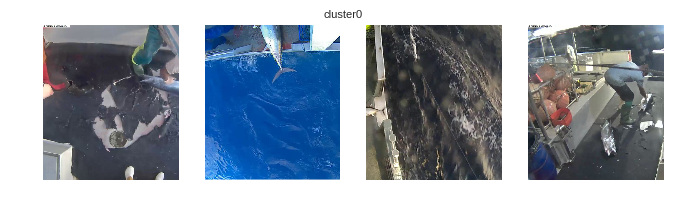

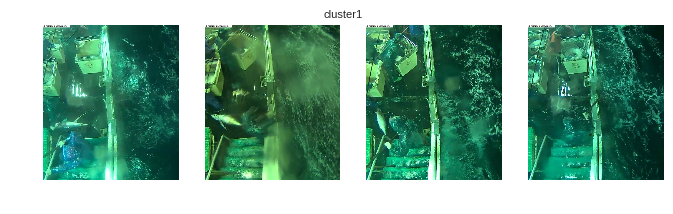

In [6]:
def show_four(imgs, title):
    _, ax = plt.subplots(1, 4, sharex='col', sharey='row', figsize=(8, 2))
    plt.suptitle(title, size=8)
    for i, img in enumerate(imgs[:4]):
        ax[i].axis('off')
        ax[i].imshow(img)

for i in range(knn_cls):
    cluster_i = training[np.where(kmeans.labels_ == i)]
    show_four(cluster_i[:4], 'cluster' + str(i))

It seems like the clustering was successful. When training locally on more images, entire training data splits successfully between night and day photos, with ~1-2 photos being misclassified, which seems like a good result, as entire training dataset consists of ~3777 images.

Running the script below should generate 'clustered' directory inside training folder, which should contain split data.

In [7]:
batch = 100
    
# now load all training examples and cluster them
CLUSTER_FOLDER = os.path.abspath('../data/clustered')
training_filenames = sorted(glob.glob('../data/train/*/*.jpg'))
    
# make directories if they doesn't exist
if not os.path.isdir(CLUSTER_FOLDER):
    os.makedirs(CLUSTER_FOLDER)
    
for cluster_num in range(knn_cls):
    single_cluster_folder = os.path.join(CLUSTER_FOLDER, str(cluster_num))
    if not os.path.isdir(single_cluster_folder):
        os.mkdir(single_cluster_folder)
    
saved_files = 0
while saved_files < len(training_filenames):
    training_files = training_filenames[saved_files:saved_files+batch]
    training = np.array([cv2.imread(img) for img in training_files])
    training_means = np.array([np.mean(img, axis=(0, 1)) for img in training])
    training_features = np.zeros((batch, 3))
    for i in range(len(training)):
        training_features[i][0] = (training_means[i][0]
                                   - training_means[i][1])
        training_features[i][0] += (training_means[i][0]
                                    - training_means[i][2])
        training_features[i][1] = (training_means[i][1]
                                   - training_means[i][0])
        training_features[i][1] += (training_means[i][1]
                                    - training_means[i][2])
        training_features[i][2] = (training_means[i][2] 
                                   - training_means[i][0])
        training_features[i][2] += (training_means[i][2] 
                                    - training_means[i][1])
            
    img_cls = kmeans.predict(training_features)
        
    for i, img in enumerate(tqdm(training)):
        cluster = img_cls[i]
        save_path = os.path.join(CLUSTER_FOLDER, str(cluster))
        class_name = os.path.basename(os.path.dirname(training_files[i]))
        save_path = os.path.join(save_path, class_name)
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        save_path = os.path.join(save_path,
                                 os.path.basename(training_files[i]))
        #print(save_path)
        cv2.imwrite(save_path, img)
        saved_files += 1
        
    print(str(saved_files) + "/" + str(len(training_filenames)))

100%|██████████| 100/100 [00:03<00:00, 26.49it/s]     | 3/100 [00:00<00:03, 28.33it/s]


100/3777


100%|██████████| 100/100 [00:03<00:00, 26.78it/s]     | 3/100 [00:00<00:03, 28.31it/s]


200/3777


100%|██████████| 100/100 [00:03<00:00, 27.62it/s]     | 3/100 [00:00<00:03, 26.92it/s]


300/3777


100%|██████████| 100/100 [00:03<00:00, 27.58it/s]     | 3/100 [00:00<00:03, 28.29it/s]


400/3777


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]     | 3/100 [00:00<00:03, 28.98it/s]


500/3777


100%|██████████| 100/100 [00:03<00:00, 27.82it/s]     | 3/100 [00:00<00:03, 28.74it/s]


600/3777


100%|██████████| 100/100 [00:03<00:00, 28.65it/s]     | 3/100 [00:00<00:03, 27.02it/s]


700/3777


100%|██████████| 100/100 [00:03<00:00, 27.08it/s]     | 4/100 [00:00<00:03, 30.88it/s]


800/3777


100%|██████████| 100/100 [00:03<00:00, 27.49it/s]     | 3/100 [00:00<00:03, 28.78it/s]


900/3777


100%|██████████| 100/100 [00:03<00:00, 27.25it/s]     | 4/100 [00:00<00:02, 33.84it/s]


1000/3777


100%|██████████| 100/100 [00:03<00:00, 28.33it/s]     | 4/100 [00:00<00:03, 31.39it/s]


1100/3777


100%|██████████| 100/100 [00:03<00:00, 27.69it/s]     | 3/100 [00:00<00:03, 29.94it/s]


1200/3777


100%|██████████| 100/100 [00:03<00:00, 28.21it/s]     | 4/100 [00:00<00:02, 32.81it/s]


1300/3777


100%|██████████| 100/100 [00:03<00:00, 28.27it/s]     | 3/100 [00:00<00:03, 24.71it/s]


1400/3777


100%|██████████| 100/100 [00:03<00:00, 27.33it/s]     | 4/100 [00:00<00:03, 31.41it/s]


1500/3777


100%|██████████| 100/100 [00:03<00:00, 27.73it/s]     | 4/100 [00:00<00:02, 32.33it/s]


1600/3777


100%|██████████| 100/100 [00:03<00:00, 27.55it/s]     | 4/100 [00:00<00:03, 31.93it/s]


1700/3777


100%|██████████| 100/100 [00:03<00:00, 25.38it/s]     | 3/100 [00:00<00:03, 28.11it/s]


1800/3777


100%|██████████| 100/100 [00:04<00:00, 24.90it/s]     | 3/100 [00:00<00:03, 28.31it/s]


1900/3777


100%|██████████| 100/100 [00:04<00:00, 24.45it/s]     | 3/100 [00:00<00:03, 26.92it/s]


2000/3777


100%|██████████| 100/100 [00:03<00:00, 26.79it/s]     | 3/100 [00:00<00:04, 23.74it/s]


2100/3777


100%|██████████| 100/100 [00:03<00:00, 26.57it/s]     | 4/100 [00:00<00:03, 30.65it/s]


2200/3777


100%|██████████| 100/100 [00:03<00:00, 25.96it/s]     | 3/100 [00:00<00:03, 27.03it/s]


2300/3777


100%|██████████| 100/100 [00:03<00:00, 25.64it/s]     | 4/100 [00:00<00:03, 29.73it/s]


2400/3777


100%|██████████| 100/100 [00:03<00:00, 26.03it/s]     | 4/100 [00:00<00:03, 31.10it/s]


2500/3777


100%|██████████| 100/100 [00:03<00:00, 27.01it/s]     | 4/100 [00:00<00:02, 35.13it/s]


2600/3777


100%|██████████| 100/100 [00:03<00:00, 27.45it/s]     | 3/100 [00:00<00:03, 27.73it/s]


2700/3777


100%|██████████| 100/100 [00:03<00:00, 25.88it/s]     | 3/100 [00:00<00:03, 27.75it/s]


2800/3777


100%|██████████| 100/100 [00:03<00:00, 25.91it/s]     | 3/100 [00:00<00:03, 29.31it/s]


2900/3777


100%|██████████| 100/100 [00:03<00:00, 24.51it/s]     | 3/100 [00:00<00:03, 29.32it/s]


3000/3777


100%|██████████| 100/100 [00:04<00:00, 24.90it/s]     | 3/100 [00:00<00:03, 26.63it/s]


3100/3777


100%|██████████| 100/100 [00:04<00:00, 23.59it/s]     | 4/100 [00:00<00:03, 28.62it/s]


3200/3777


100%|██████████| 100/100 [00:04<00:00, 24.80it/s]     | 3/100 [00:00<00:03, 26.92it/s]


3300/3777


100%|██████████| 100/100 [00:03<00:00, 25.07it/s]     | 3/100 [00:00<00:03, 26.50it/s]


3400/3777


100%|██████████| 100/100 [00:03<00:00, 24.93it/s]     | 4/100 [00:00<00:03, 30.11it/s]


3500/3777


100%|██████████| 100/100 [00:04<00:00, 24.65it/s]     | 3/100 [00:00<00:04, 22.84it/s]


3600/3777


100%|██████████| 100/100 [00:04<00:00, 24.98it/s]     | 3/100 [00:00<00:03, 28.40it/s]


3700/3777


100%|██████████| 77/77 [00:03<00:00, 24.57it/s]      | 4/77 [00:00<00:02, 28.63it/s]

3777/3777


One idea that makes sense, would be to develop and apply some kind of "night" filter to make all images look like they come from same distribution (which should be easier than a "day" filter, as intuitively night photos contain less color information than day photos, and it is probably easier to "lose" some information than to "gain" it), but I have no experience in image processing and apart from simple heuristics, I can't come up with approach that would look natural.

This is my first take on a serious kaggle competition, and first kernel ever, so any feedback is welcome ;)
(I suspect some of my heuristics are a little more complicated than they should be,  and maybe some of them don't even make much sense...)